# CAX: Cellular Automata Accelerated in JAX [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/00_getting_started.ipynb) [![Paper](http://img.shields.io/badge/paper-arxiv.2410.02651-B31B1B.svg)](https://arxiv.org/abs/2410.02651)

CAX is a high-performance and flexible open-source library designed to **accelerate artificial life research**. 🧬

## Abstract

Cellular automata have become a cornerstone for investigating emergence and self-organization across diverse scientific disciplines. However, the absence of a hardware-accelerated cellular automata library limits the exploration of new research directions, hinders collaboration, and impedes reproducibility. In this work, we introduce CAX (Cellular Automata Accelerated in JAX), a high-performance and flexible open-source library designed to accelerate cellular automata research. CAX delivers cutting-edge performance through hardware acceleration while maintaining flexibility through its modular architecture, intuitive API, and support for both discrete and continuous cellular automata in arbitrary dimensions. We demonstrate CAX's performance and flexibility through a wide range of benchmarks and applications. From classic models like elementary cellular automata and Conway's Game of Life to advanced applications such as growing neural cellular automata and self-classifying MNIST digits, CAX speeds up simulations up to 2,000 times faster. Furthermore, we demonstrate CAX's potential to accelerate research by presenting a collection of three novel cellular automata experiments, each implemented in just a few lines of code thanks to the library's modular architecture. Notably, we show that a simple one-dimensional cellular automaton can outperform GPT-4 on the 1D-ARC challenge.

![Self-autoencoding MNIST Digits](../docs/ca_types.png)

## Cellular Automata

A *cellular automaton* is a simple model of computation consisting of a regular grid of cells, each in a particular state. The grid can be in any finite number of dimensions. For each cell, a set of cells called its *neighborhood* is defined relative to the specified cell. The grid is updated at discrete time steps according to a fixed rule that determines the new state of each cell based on its current state and the states of the cells in its neighborhood.

## CAX Architecture

CAX introduces a unifying framework for *all cellular automata types*. This flexible architecture is
built upon two key components: the **perceive** module and the **update** module. Together, these modules define the local rule of the CA. At each time step, this local rule is applied uniformly to all cells in the grid, generating the next global state of the system.

![CAX architecture](../docs/architecture.png)

Figure adapted from "Growing Neural Cellular Automata", Mordvintsev et al. (2020), under CC-BY 4.0 license.

CAX's architecture introduces the novel concept of **Controllable Cellular Automata** that extend the capabilities of traditional CAs by making them responsive to external inputs, akin to recurrent neural networks processing sequential data, see Figure above. Controllable cellular automata bridge the gap between recurrent convolutional neural networks and cellular automata, opening up new possibilities for modeling complex systems that exhibit both autonomous emergent behavior and responsiveness to external control.

For CA experiments with external inputs, see [examples/41_growing_conditional_nca.ipynb](../examples/41_growing_conditional_nca.ipynb) and [examples/42_growing_unsupervised_nca.ipynb](../examples/42_growing_unsupervised_nca.ipynb) for example.

## Let's dive in

In this notebook, we will explore how to use CAX to both:
- instantiate classic cellular automata like the Game of Life and
- create custom cellular automata from scratch.

You'll learn the fundamental concepts and implementation techniques that make CAX a powerful framework for cellular automata experimentation.

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [2]:
import jax
import jax.numpy as jnp
import mediapy
from flax import nnx

## Explore read-to-use cellular automata

In this section, we'll demonstrate the basic usage of CAX with pre-implemented cellular automata. We'll instantiate Conway's Game of Life and visualize a glider pattern, showing how easily you can get started with existing models in the library.

### Configuration

First, we set up the configuration, including seed, spatial dimensions and the number of steps.

In [2]:
seed = 0

spatial_dims = (32, 32)

num_steps = 128

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

### Model

Next, we instantiate Conway's Game of Life.

In [3]:
from cax.models.life import Life

ca = Life(rngs=rngs)

### Sample initial state

Then, we define a function to sample an initial state, which is essential for running a model.

In [4]:
def sample_state():
	"""Sample a state with a glider for the Game of Life."""
	state = jnp.zeros((*spatial_dims, 1))

	mid_x, mid_y = spatial_dims[0] // 2, spatial_dims[1] // 2
	glider = jnp.array(
		[
			[0.0, 1.0, 0.0],
			[0.0, 0.0, 1.0],
			[1.0, 1.0, 1.0],
		]
	)
	return state.at[mid_x : mid_x + 3, mid_y : mid_y + 3, 0].set(glider)

### Run

Given an initial state and the model, we can simulate for `num_steps`.

In [6]:
state_init = sample_state()
state_final, states = ca(state_init, num_steps=num_steps)

### Visualize

Finally, we can visualize the trajectory of states.

All models should include a `render` method to convert a state into an RGB frame. For the Game of Life, a ready-to-use `render` method is provided, allowing you to easily generate a frame with a simple call: `frame = ca.render(state)`.

Enjoy! 👾

""

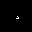

In [6]:
states = jnp.concatenate([state_init[None], states])  # concatenate initial state with other states
frames = jax.vmap(ca.render)(states)  # render each frame

mediapy.show_video(frames, width=256, height=256, codec="gif")

### Custom metrics functions

While visualizing the trajectory of states can produce captivating simulations, we often also want to track additional metrics to better understand how the model evolves over time.

By default, the metrics function in CAX returns the states encountered during the model’s rollout. However, this behavior is highly customizable. In this section, we’ll explore how to create a tailored metrics function to log custom metrics suited to your needs.

A metrics function must accept the next state, the current state, the perception, and the input as its parameters. For the Game of Life, however, the input parameter is not utilized, and can safely be ignored.

In [7]:
def custom_metrics_fn(next_state, state, perception, input):
	"""Metrics function customized for the Game of Life."""
	neighbors_alive_count = perception[..., 1:2]
	return {
		"state": next_state,
		"num_neighbors": jnp.mean(neighbors_alive_count),
		"growth_rate": jnp.sum(next_state) - jnp.sum(state),
	}

Let's instantiate the Game of Life with this custom metrics function.

In [8]:
ca = Life(rngs=rngs, metrics_fn=custom_metrics_fn)

This time, we will generate a state composed of randomly initialized cells, drawn from a Bernoulli distribution where each cell has a 0.1 probability of being alive.

In [9]:
def sample_state(key, p=0.1):
	"""Sample a random state for the Game of Life."""
	return jax.random.bernoulli(key, p=p, shape=(*spatial_dims, 1)).astype(jnp.float32)

Let's run the model:

In [22]:
key, subkey = jax.random.split(key)
state_init = sample_state(subkey)
state_final, metrics = ca(state_init, num_steps=num_steps)

...and visualize:

""

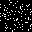

In [23]:
states = jnp.concatenate([state_init[None], metrics["state"]])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

Let's also plot the number of alive neighbors and growth rate over time:

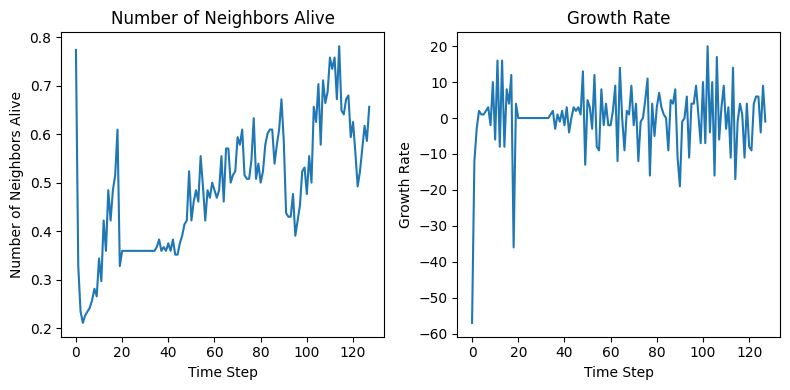

In [24]:
import matplotlib.pyplot as plt

# Plot the metrics
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(metrics["num_neighbors"])
axes[0].set_title("Number of Neighbors Alive")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Number of Neighbors Alive")

axes[1].plot(metrics["growth_rate"])
axes[1].set_title("Growth Rate")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Growth Rate")

plt.tight_layout()
plt.show()

## Create your own cellular automata from scratch

In this section, we will build a cellular automaton from scratch using custom Perceive and Update modules. We'll implement a small neural cellular automaton featuring convolutional perception and residual update mechanisms. Note that we won't be training this neural cellular automaton in the current notebook - we'll focus solely on its construction and architecture.

Since each NCA is unique, CAX does not offer pre-built, ready-to-use NCAs. However, it provides a versatile toolkit that empowers users to swiftly develop a custom cellular automaton suited to their specific experimental needs. In this section, we will explore how to efficiently create a neural cellular automaton using these tools.

### Configuration

In [42]:
seed = 0

num_spatial_dims = 2
channel_size = 16

num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

### Perceive

CAX provides a set of perceive models. In this notebook, we will use a simple convolution perceive module.

In [43]:
from cax.core.perceive import ConvPerceive

perceive = ConvPerceive(
	channel_size=channel_size,  # Number of channels per cell in the grid
	perception_size=2 * channel_size,  # Number of channels per cell in the perception
	rngs=rngs,
)

### Update

CAX provides a set of update models. In this notebook, we will use a residual MLP update module.

In [44]:
from cax.core.update import ResidualUpdate

update = ResidualUpdate(
	num_spatial_dims=2,  # Number of spatial dimensions
	channel_size=channel_size,  # Number of channels per cell in the grid
	perception_size=2 * channel_size,  # Number of channels per cell in the perception
	hidden_layer_sizes=(hidden_size,),  # Sizes of hidden layers in the MLP
	rngs=rngs,
)

### Cellular Automata

The final step to create the cellular automata is to combine the perceive and update modules.

Optionally, we can create a custom CA class inheriting from the base CA class to implement a custom render method and more.

In [47]:
from cax.core.ca import CA
from cax.utils.render import clip_and_uint8, rgba_to_rgb


class MyCustomCA(CA):
	"""My custom cellular automaton."""

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		rgba = state[..., -4:]
		rgb = rgba_to_rgb(rgba)

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

In [48]:
ca = MyCustomCA(perceive, update)

### Sample initial state

""

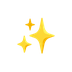

In [49]:
import PIL
from cax.utils.emoji import get_emoji

size = 40
pad_width = 16

emoji_pil = get_emoji("✨")
emoji_pil = emoji_pil.resize((size, size), resample=PIL.Image.Resampling.LANCZOS)

y = jnp.array(emoji_pil, dtype=jnp.float32) / 255.0
y = jnp.pad(y, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)))

mediapy.show_image(y)

In [50]:
def sample_state(y):
	"""Sample a state with the target image."""
	state_shape = y.shape[:2] + (channel_size,)
	state = jnp.zeros(state_shape)

	# Set the target image in the RGB channels
	return state.at[:, :, :4].set(y)

### Visualize

Run the cellular automata for 256 steps.

In [51]:
state_init = sample_state(y)
state_final, states = ca(state_init, num_steps=256)

Clip the states to display as a video.

In [52]:
states = jnp.clip(jnp.concatenate([state_init[None], states]), min=0.0, max=1.0)

Now you know how to run cellular automata with CAX! Go through the other notebooks to understand how to run classic cellular automata such as Game of Life or Lenia, or train neural cellular automata such as growing neural cellular automata.


""

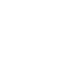

In [53]:
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")